In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length
0,2023-02-01 19:59:48+00:00,"Dank voor bericht, Marijke",kooky-tapir,False,False,26,False,evening,19:59:48,2,26
1,2023-02-01 20:46:43+00:00,"Herman goede avond, Mag ik de telefoon nummer...",dynamic-frog,False,False,87,False,evening,20:46:43,2,87
2,2023-02-01 20:52:10+00:00,Voor Ista metertje: 010 2455700,intense-toad,False,True,31,False,evening,20:52:10,2,31
3,2023-02-01 20:52:45+00:00,"Dit gaat dus via Ista, niet via De Combi",intense-toad,False,True,40,False,evening,20:52:45,2,40
4,2023-02-01 20:55:55+00:00,Bedankt Herman 👍🏽🙏🏽,dynamic-frog,True,False,19,False,evening,20:55:55,2,19


<Axes: xlabel='message_length', ylabel='Count'>

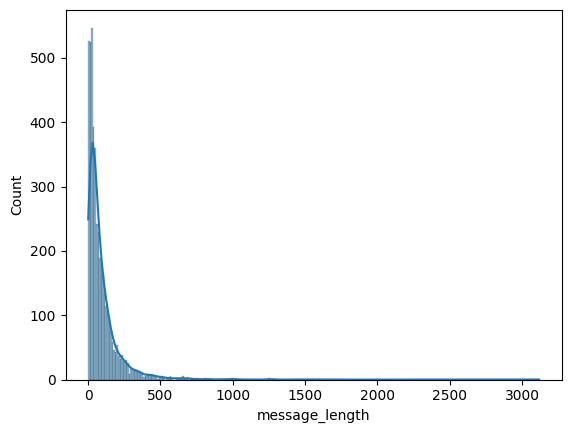

In [3]:
sns.histplot(df, x="message_length", kde=True)

<Axes: xlabel='log_len', ylabel='Count'>

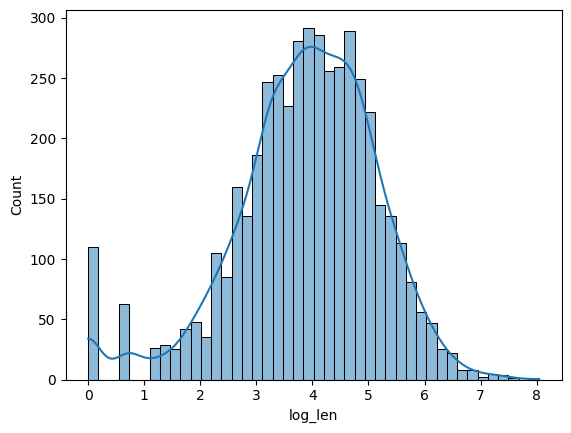

In [4]:
import numpy as np

df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
sns.histplot(df, x="log_len", kde=True)

In [5]:
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length,log_len
0,2023-02-01 19:59:48+00:00,"Dank voor bericht, Marijke",kooky-tapir,False,False,26,False,evening,19:59:48,2,26,3.258097
1,2023-02-01 20:46:43+00:00,"Herman goede avond, Mag ik de telefoon nummer...",dynamic-frog,False,False,87,False,evening,20:46:43,2,87,4.465908
2,2023-02-01 20:52:10+00:00,Voor Ista metertje: 010 2455700,intense-toad,False,True,31,False,evening,20:52:10,2,31,3.433987
3,2023-02-01 20:52:45+00:00,"Dit gaat dus via Ista, niet via De Combi",intense-toad,False,True,40,False,evening,20:52:45,2,40,3.688879
4,2023-02-01 20:55:55+00:00,Bedankt Herman 👍🏽🙏🏽,dynamic-frog,True,False,19,False,evening,20:55:55,2,19,2.944439


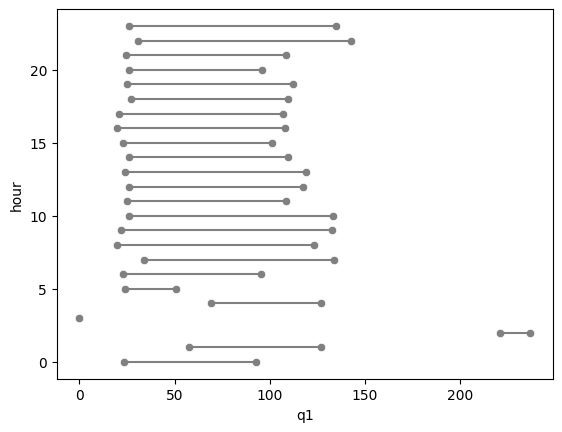

In [6]:
def q1(x):
    return np.quantile(x, 0.25)
def q3(x):
    return np.quantile(x, 0.75)

df["hour"] = df.timestamp.dt.hour
quantiles = df.groupby("hour")["message_length"].agg([q1, q3])
quantiles.columns = ["q1", "q3"]

p = quantiles.reindex(range(24), fill_value=0)

sns.scatterplot(data=p, x="q1", y=p.index, color="grey")
sns.scatterplot(data=p, x="q3", y=p.index, color="grey")
for index, row in p.iterrows():
    sns.lineplot(x=[row["q1"], row["q3"]], y=[index, index], color="grey")

Text(0.5, 1.0, 'Wanneer zijn berichten langer?')

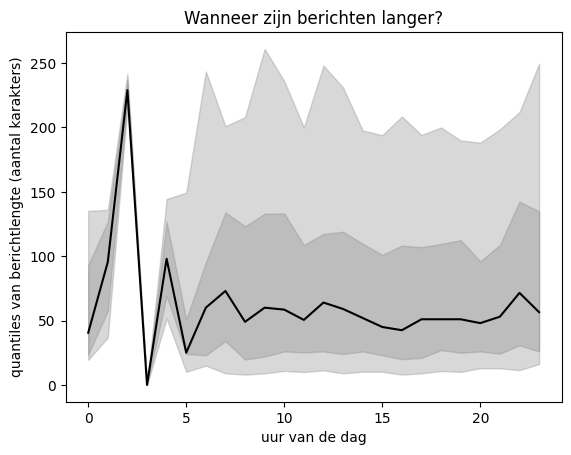

In [7]:
def q1(x):
    return np.quantile(x, 0.1)
def q2(x):
    return np.quantile(x, 0.25)
def q3(x):
    return np.quantile(x, 0.5)
def q4(x):
    return np.quantile(x, 0.75)
def q5(x):
    return np.quantile(x, 0.9)

df["hour"] = df.timestamp.dt.hour
quantiles = df.groupby("hour")["message_length"].agg([q1, q2, q3, q4, q5])
quantiles.columns = ["q1", "q2", "q3", "q4", "q5"]
p = quantiles.reindex(range(24), fill_value=0)

plt.plot(p.index, p["q3"], color="black")
plt.fill_between(p.index, p["q2"], p["q4"], color="grey", alpha=0.3)
plt.fill_between(p.index, p["q1"], p["q5"], color="grey", alpha=0.3)
plt.xlabel("uur van de dag")
plt.ylabel("quantiles van berichtlengte (aantal karakters)")
plt.title("Wanneer zijn berichten langer?")